<a href="https://colab.research.google.com/github/raquel-pinheiro/Machine-Learning-Models/blob/main/Credit_Default_Prediction_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTS, DATA CLEANING**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, precision_recall_curve
)

In [ ]:
df = pd.read_csv('credit_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   clientid  2000 non-null   int64  
 1   income    2000 non-null   float64
 2   age       1997 non-null   float64
 3   loan      2000 non-null   float64
 4   default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.3 KB


In [ ]:
display(df.head())

,clientid,income,age,loan,default
0,1,66155.93,59.02,8106.53,0
1,2,34415.15,48.12,6564.75,0
2,3,57317.17,63.11,8020.95,0
3,4,42709.53,45.75,6103.64,0
4,5,66952.69,18.58,8770.10,1


In [ ]:
display(df.describe())

,clientid,income,age,loan,default
count,2000.00,2000.00,1997.00,2000.00,2000.00
mean,1000.50,45331.60,40.81,4444.37,0.14
std,577.49,14326.33,13.62,3045.41,0.35
min,1.00,20014.49,-52.42,1.38,0.00
25%,500.75,32796.46,28.99,1939.71,0.00
50%,1000.50,45789.12,41.32,3974.72,0.00
75%,1500.25,57791.28,52.59,6432.41,0.00
max,2000.00,69995.69,63.97,13766.05,1.00


In [ ]:
df.isnull().sum()

,0
clientid,0
income,0
age,3
loan,0
default,0


In [ ]:
invalid_age = (df['age'] < 0) | (df['age'] > 100)
df.loc[invalid_age, 'age'] = np.nan

In [ ]:
imputer = SimpleImputer(strategy='median')
df[['age']] = imputer.fit_transform(df[['age']])

In [ ]:
#comparison with and without feature engineering
y = df['default']

X_basic = df[['income','age','loan']]

df['dti'] = df['loan'] / df['income']
X_dti = df[['income','age','loan','dti']]

In [ ]:
def eval_model(X, y):
    pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])

    scores = cross_val_score(pipe, X, y,
                             cv=5,
                             scoring='roc_auc',
                             n_jobs=-1)

    return scores.mean(), scores.std()

mean_basic, std_basic = eval_model(X_basic, y)
mean_dti, std_dti = eval_model(X_dti, y)

print(f"ROC-AUC with DTI: {mean_basic:.4f} ± {std_basic:.4f}")
print(f"ROC-AUC with DTI: {mean_dti:.4f} ± {std_dti:.4f}")

ROC-AUC with DTI: 0.9982 ± 0.0011
ROC-AUC with DTI: 1.0000 ± 0.0000


**DTI Improved Model to Maximal Performance**

# **MODEL DEVELOPMENT**
## Random Forest


*   Good performance on small datasets
*   Robust to overfitting
*   Handles non-linear relationships
*   Insensitive to scaling
*   Robust to noise and missing values



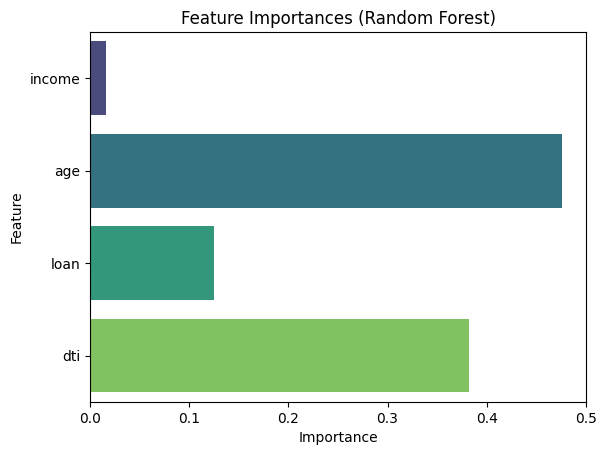

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X_dti, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])
pipe.fit(X_tr, y_tr)

importances = pipe.named_steps['rf'].feature_importances_
feat_names = X_dti.columns

sns.barplot(x=importances, y=feat_names, palette='viridis')
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**AGE & DTI Main Drivers**

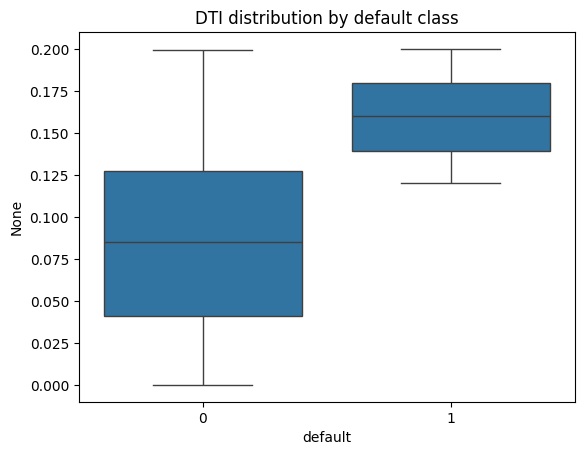

In [ ]:
import seaborn as sns

sns.boxplot(x=df['default'], y=df['loan']/df['income'])
plt.title('DTI distribution by default class')
plt.show()

**DTI Essential To Discover 0.125 Limit Between 0 and 1 Classes**

In [ ]:
df_model = df.drop(columns=['clientid'])
X = df_model.drop(columns='default')
y = df_model['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       343
           1     1.0000    1.0000    1.0000        57

    accuracy                         1.0000       400
   macro avg     1.0000    1.0000    1.0000       400
weighted avg     1.0000    1.0000    1.0000       400



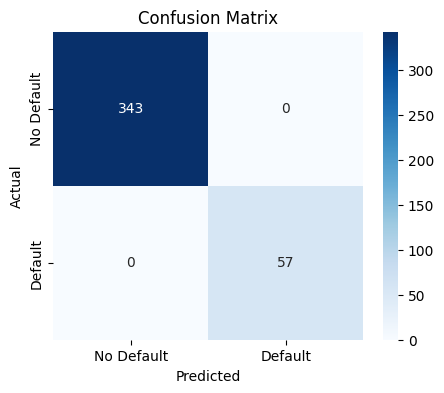

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default','Default'],
            yticklabels=['No Default','Default'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

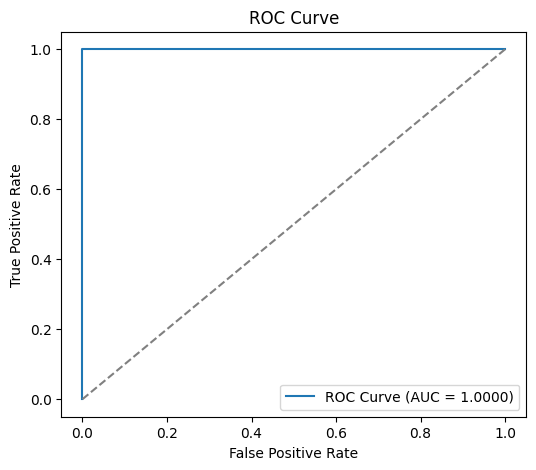

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0,1],[0,1],'--', c='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend()
plt.show()

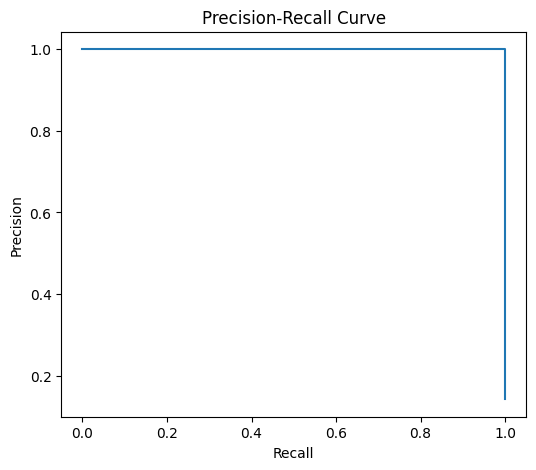

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Excelent Results**



*   recall = 1
*   f1-score = 1
*   precision = 1
*   accuracy = 1






# **TEST IN NEW DATA**

In [ ]:
new_applicants = pd.DataFrame([
    {'income': 50000, 'age': 30, 'loan': 4000},
    {'income': 25000, 'age': 22, 'loan': 8000},
    {'income': 70000, 'age': 55, 'loan': 12000},
    {'income': 2000, 'age': 18, 'loan': 500}
])
new_applicants['dti'] = new_applicants['loan'] / new_applicants['income']

In [ ]:
predictions = rf.predict(new_applicants)
probabilities = rf.predict_proba(new_applicants)[:, 1]

In [ ]:
result = new_applicants.copy()
result['default_pred'] = predictions
result['default_prob'] = probabilities
display(result)

,income,age,loan,dti,default_pred,default_prob
0,50000,30,4000,0.08,0,0.00
1,25000,22,8000,0.32,1,0.98
2,70000,55,12000,0.17,0,0.00
3,2000,18,500,0.25,1,0.84
